Data Preprocessing

In [10]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [11]:
def load_data(file_paths):
    """Load CSV files and extract Close prices, aligning by date."""
    dfs = [pd.read_csv(fp, parse_dates=['Date'], index_col='Date')['Close'] for fp in file_paths]
    data = pd.concat(dfs, axis=1).dropna()
    data.columns = ['VTI', 'AGG', 'DBC', 'VIX']
    return data

def calculate_returns(data):
    """Calculate daily returns from close prices."""
    returns = data.pct_change().dropna()
    return returns

def standardize_data(train_data, test_data):
    """Standardize prices and returns using training data statistics."""
    price_means = train_data.mean()
    price_stds = train_data.std()
    train_prices_std = (train_data - price_means) / price_stds
    test_prices_std = (test_data - price_means) / price_stds
    
    return_means = train_prices_std.pct_change().dropna().mean()
    return_stds = train_prices_std.pct_change().dropna().std()
    train_returns = train_prices_std.pct_change().dropna()
    test_returns = test_prices_std.pct_change().dropna()
    train_returns_std = (train_returns - return_means) / return_stds
    test_returns_std = (test_returns - return_means) / return_stds
    
    return train_prices_std, test_prices_std, train_returns_std, test_returns_std

def create_sequences(prices, returns, lookback=50):
    """Create input sequences and next-day returns for training/testing."""
    sequences = []
    for t in range(lookback, len(prices) - 1):
        price_seq = prices.iloc[t - lookback:t].values  # (50, 4)
        return_seq = returns.iloc[t - lookback:t].values  # (50, 4)
        x = np.hstack([price_seq, return_seq])  # (50, 8)
        r_next = returns.iloc[t].values  # (4,)
        sequences.append((x, r_next))
    return sequences

In [12]:
class PortfolioDataset(Dataset):
    """Custom Dataset for using it with Dataloader class of pytorch."""
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        x, r_next = self.sequences[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(r_next, dtype=torch.float32)

Model

In [13]:
class PortfolioLSTM(torch.nn.Module):
    def __init__(self, input_size=8, hidden_size=64, num_layers=1, num_assets=4):
        super(PortfolioLSTM, self).__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, num_assets)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]
        out = self.fc(last_output)
        weights = self.softmax(out)
        return weights

CARA Loss function

In [14]:
def cara_utility_loss(weights, r_next, alpha=1.0):
    portfolio_returns = torch.sum(weights * r_next, dim=1)
    utility = -torch.exp(-alpha * portfolio_returns)
    return -utility.mean()

Training the Model

In [15]:
def train_model(model, train_loader, val_sequences, num_epochs=100, alpha=0.1, lr=0.001, patience=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    patience_counter = 0

    val_x = torch.tensor([x for x, _ in val_sequences], dtype=torch.float32)
    val_y = torch.tensor([y for _, y in val_sequences], dtype=torch.float32)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            weights = model(batch_x)
            loss = cara_utility_loss(weights, batch_y, alpha)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch_x.size(0)

        avg_loss = total_loss / len(train_loader.dataset)

        model.eval()
        with torch.no_grad():
            val_weights = model(val_x)
            val_loss = cara_utility_loss(val_weights, val_y, alpha).item()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.6f}, Val Loss: {val_loss:.6f}")

        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return model

Performance Matrices

In [16]:
def calculate_maximum_drawdown(returns):
    """Calculate maximum drawdown from return series."""
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    return drawdown.min()

def calculate_sortino_ratio(returns, risk_free_rate=0.02):
    """Calculate Sortino ratio."""
    excess_returns = returns - risk_free_rate/252  # Daily risk-free rate
    downside_returns = excess_returns[excess_returns < 0]
    downside_deviation = np.sqrt(np.mean(downside_returns**2)) * np.sqrt(252)
    
    if downside_deviation == 0:
        return np.inf
    return (np.mean(excess_returns) * 252) / downside_deviation

def calculate_alpha_beta(portfolio_returns, market_returns, risk_free_rate=0.02):
    """Calculate alpha and beta using linear regression."""
    # Convert to excess returns
    portfolio_excess = portfolio_returns - risk_free_rate/252
    market_excess = market_returns - risk_free_rate/252
    
    # Calculate beta using linear regression
    beta, alpha_daily, r_value, p_value, std_err = stats.linregress(market_excess, portfolio_excess)
    
    # Annualize alpha
    alpha_annual = alpha_daily * 252
    
    return alpha_annual, beta, r_value**2

def rolling_window_analysis(returns, window_size=63):  # ~3 months
    """Perform rolling window analysis of key metrics."""
    results = []
    
    for i in range(window_size, len(returns)):
        window_returns = returns.iloc[i-window_size:i]
        
        # Calculate metrics for this window
        mean_return = window_returns.mean() * 252
        volatility = window_returns.std() * np.sqrt(252)
        sharpe = mean_return / volatility if volatility > 0 else 0
        max_dd = calculate_maximum_drawdown(window_returns)
        sortino = calculate_sortino_ratio(window_returns)
        
        results.append({
            'Date': returns.index[i-1],
            'Annualized_Return': mean_return,
            'Volatility': volatility,
            'Sharpe_Ratio': sharpe,
            'Sortino_Ratio': sortino,
            'Max_Drawdown': max_dd
        })
    
    return pd.DataFrame(results)

Testing the Model

In [17]:
device = torch.device('mps' if torch.mps.is_available() else 'cpu')

def test_model(model, test_sequences, returns, market_returns=None, sigma_tgt=0.10, C=0.0001, risk_free_rate=0.02):
    """Enhanced test function with comprehensive performance metrics in percentages."""
    model.eval()
    R_p_net = []
    scaled_w_prev = np.zeros(4)
    sigma_i = returns.ewm(span=50).std() * np.sqrt(252)  # Annualized volatility
    
    # Store portfolio weights for analysis
    portfolio_weights = []
    
    for t in range(len(test_sequences)):
        x, _ = test_sequences[t]
        r_t = returns.iloc[t + 50].values  # Align with sequence index
        sigma_i_t = sigma_i.iloc[t + 50].values
        
        with torch.no_grad():
            weights = model(torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)).cpu().numpy()[0]
        
        scaled_w = (sigma_tgt / sigma_i_t) * weights
        portfolio_weights.append(scaled_w.copy())
        
        cost = C * np.sum(np.abs(scaled_w - scaled_w_prev)) if t > 0 else 0
        R_p = np.sum(scaled_w * r_t) - cost
        R_p_net.append(R_p)
        scaled_w_prev = scaled_w
    
    # Convert to pandas Series for easier manipulation
    portfolio_returns = pd.Series(R_p_net, index=returns.iloc[50:50+len(R_p_net)].index)
    
    # Calculate comprehensive metrics
    mean_return = np.mean(R_p_net)
    std_return = np.std(R_p_net, ddof=1)
    
    # Annualized metrics
    annual_return = mean_return * 252
    annual_volatility = std_return * np.sqrt(252)
    sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility if annual_volatility > 0 else 0
    
    # Additional metrics
    total_return = (1 + portfolio_returns).prod() - 1
    max_drawdown = calculate_maximum_drawdown(portfolio_returns)
    sortino_ratio = calculate_sortino_ratio(portfolio_returns, risk_free_rate)
    excess_return = annual_return - risk_free_rate
    
    # Alpha and Beta 
    if market_returns is not None:
        # Align market returns with portfolio returns
        aligned_market = market_returns.loc[portfolio_returns.index]
        if len(aligned_market) == len(portfolio_returns):
            alpha, beta, r_squared = calculate_alpha_beta(portfolio_returns, aligned_market, risk_free_rate)
        else:
            alpha, beta, r_squared = np.nan, np.nan, np.nan
    else:
        alpha, beta, r_squared = np.nan, np.nan, np.nan
    
    # Rolling window analysis
    rolling_stats = rolling_window_analysis(portfolio_returns)
    
    # Print results with percentages
    print("PORTFOLIO PERFORMANCE METRICS")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"Sortino Ratio: {sortino_ratio:.4f}")
    if not np.isnan(alpha):
        print(f"Alpha (%): {alpha * 100:.4f}%")
    else:
        print(f"Alpha (%): N/A")
    if not np.isnan(beta):
        print(f"Beta: {beta:.4f}")
    else:
        print(f"Beta: N/A")
    
    # REQUESTED METRICS IN PERCENTAGES
    print(f"Excess Return (%): {excess_return * 100:.4f}%")
    print(f"Total Return (%): {total_return * 100:.4f}%")
    print(f"Maximum Drawdown (%): {max_drawdown * 100:.4f}%")
    
    print()
    print("ADDITIONAL METRICS")
    print(f"Expected Return (Annualized %): {annual_return * 100:.4f}%")
    print(f"Volatility (Annualized %): {annual_volatility * 100:.4f}%")
    print(f"Standard Deviation: {annual_volatility:.4f}")
    
    return {
        'sharpe_ratio': sharpe_ratio,
        'sortino_ratio': sortino_ratio,
        'alpha': alpha if not np.isnan(alpha) else None,
        'beta': beta if not np.isnan(beta) else None,
        'excess_return_pct': excess_return * 100,
        'total_return_pct': total_return * 100,
        'max_drawdown_pct': max_drawdown * 100,
        'annual_return_pct': annual_return * 100,
        'annual_volatility_pct': annual_volatility * 100,
        'portfolio_returns': portfolio_returns,
        'portfolio_weights': portfolio_weights
    }

Plots of the cumulative returns of the individual ETFs along with the optimised portfolio And Main Function

PORTFOLIO PERFORMANCE METRICS
Sharpe Ratio: 2.4063
Sortino Ratio: 2.1607
Alpha (%): 8.2887%
Beta: 0.1395
Excess Return (%): 9.8810%
Total Return (%): 9.9155%
Maximum Drawdown (%): -2.3273%

ADDITIONAL METRICS
Expected Return (Annualized %): 11.8810%
Volatility (Annualized %): 4.1062%
Standard Deviation: 0.0411


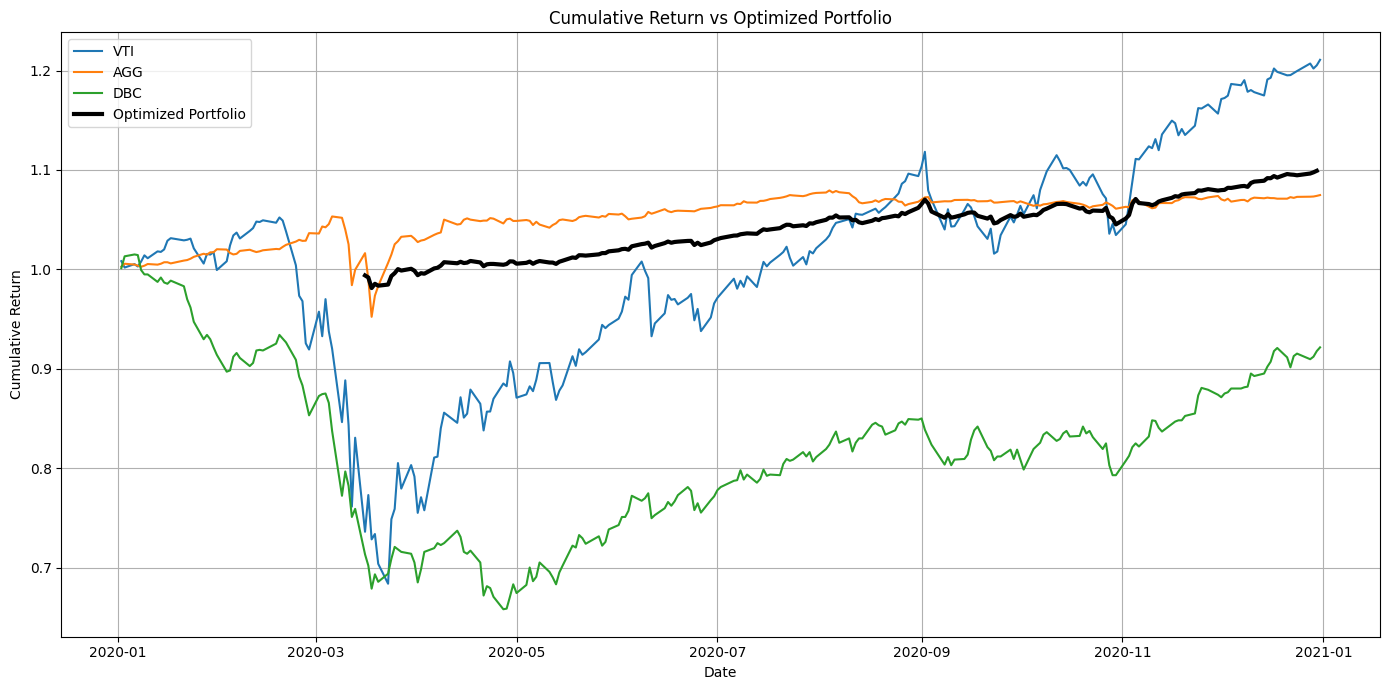

In [18]:
if __name__ == "__main__":
    file_paths = ['VTI.csv', 'AGG.csv', 'DBC.csv', 'VIX.csv']
    data = load_data(file_paths)
    returns = calculate_returns(data)

    # Define periods
    train_start = '2015-01-01'
    train_end = '2018-12-31'
    test_start = '2020-01-01'
    test_end = '2020-12-31'
    
    train_data = data[(data.index >= train_start) & (data.index < train_end)]
    test_data = data[(data.index >= test_start) & (data.index <= test_end)]
    
    train_prices_std, test_prices_std, train_returns_std, test_returns_std = standardize_data(train_data, test_data)

    # Load model
    model = PortfolioLSTM().to(device)
    state_dict = torch.load('best_model.pt', weights_only=True)
    model.load_state_dict(state_dict)

    # Prepare test data
    test_returns = returns.loc[test_prices_std.index]
    test_sequences = create_sequences(test_prices_std, test_returns_std)
    
    # Get benchmark returns as the mean of all 4 ETFs
    benchmark_prices = test_data.mean(axis=1)
    benchmark_returns = benchmark_prices.pct_change()

    # Safely align the benchmark_returns index with test_returns
    benchmark_returns = benchmark_returns.reindex(test_returns.index).fillna(0)
    market_returns = benchmark_returns

    
    # Run testing with all metrics
    results = test_model(model, test_sequences, test_returns, market_returns, sigma_tgt=0.1, C=0.0001)
    # Compute cumulative returns for individual ETFs during the test period (excluding VIX)
    cumulative_returns_etfs = (1 + test_returns.drop(columns='VIX')).cumprod()

    # Compute cumulative return for the optimized portfolio
    cumulative_returns_portfolio = (1 + results['portfolio_returns']).cumprod()

    # Plotting
    plt.figure(figsize=(14, 7))
    for col in cumulative_returns_etfs.columns:
        plt.plot(cumulative_returns_etfs.index, cumulative_returns_etfs[col], label=col)


    plt.plot(cumulative_returns_portfolio.index, cumulative_returns_portfolio, label='Optimized Portfolio', linewidth=3, color='black')

    plt.title('Cumulative Return vs Optimized Portfolio')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()